# This is the code for analyzing the hourly series, using sleuth outputs. 

The "new filter" in the names refers to the stricter filter we set on sleuth to filter out more low-count reads.

Files required to run this notebook are:
- 'hourly_full_new_filter.csv' which contains the spline coefficients for each isoform
- 'time_spline_X.csv' which contains the basis functions for the natural cubic spline for 20 time points
- 'hourly_de_new_filter.csv' which contains a list of DE genes from aggregated isoforms
- 't2g.csv' which is the same transcript-to-gene annotation used in the R script as a csv file
- 'pval_agg_spline_and_cond_mtx.csv' which is the normalized (DESeq normalization) counts matrix
- 'tpm_mtx.csv' which contains the TPMs for each isoform

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import math
import h5py
#from scipy.interpolate import UnivariateSpline
#from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

## Importing data

In [3]:
full = pd.read_csv('hourly_full_new_filter.csv', index_col=0)
full.head()

,target_id,term,estimate,std_error
1,ENST00000000233.10,grouppre_vaccination,6.326650,1.224882
2,ENST00000000233.10,grouppost_vaccination,-2.027570,1.224882
3,ENST00000000233.10,grouppre_vaccination:X1,-0.542093,1.823437
4,ENST00000000233.10,grouppost_vaccination:X1,-3.054911,1.823437
5,ENST00000000233.10,grouppre_vaccination:X2,-0.077111,2.180033


In [4]:
full.shape

(150432, 4)

In [5]:
full['target_id'] = full['target_id'].str.split('.',expand=False).str[0]
full.shape

(150432, 4)

In [6]:
time = pd.read_csv('time_spline_X.csv', index_col=0)
time = time.reset_index(drop=True)
time = time.iloc[0:20]
time.head()

,1,2,3,4,5
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.003037,0.000000,-0.065182,0.195547,-0.130365
2,0.024299,0.000000,-0.121124,0.363371,-0.242247
3,0.082009,0.000000,-0.158582,0.475746,-0.317164
4,0.194295,0.000024,-0.168347,0.505041,-0.336694


In [7]:
de = pd.read_csv('hourly_de_new_filter.csv', index_col=0)
de.head()

,target_id,ext_gene,num_aggregated_transcripts,sum_mean_obs_counts,pval,qval
1,ENSG00000274058,TMPRSS11E,1,6.165804,1.014458e-08,0.000082
2,ENSG00000011600,TYROBP,6,25.230532,2.408955e-08,0.000098
3,ENSG00000197111,PCBP2,8,32.912757,3.672004e-08,0.000099
4,ENSG00000076944,STXBP2,10,41.417813,1.198264e-07,0.000243
5,ENSG00000117984,CTSD,3,14.488798,1.860908e-07,0.000250


In [8]:
t2g = pd.read_csv('t2g.csv', index_col = 0)
t2g_valid = t2g.loc[t2g['target_id'].isin(full['target_id'])==True]
t2g_valid.shape

(12536, 3)

In [9]:
t2g_valid.head()

,target_id,ens_gene,ext_gene
6,ENST00000361390,ENSG00000198888,MT-ND1
10,ENST00000361453,ENSG00000198763,MT-ND2
16,ENST00000361624,ENSG00000198804,MT-CO1
19,ENST00000361739,ENSG00000198712,MT-CO2
21,ENST00000361851,ENSG00000228253,MT-ATP8


In [10]:
len(t2g_valid['ens_gene'].unique())

8099

In [12]:
# Checking if all isoforms of DE genes are in the t2g

for index, row in de.iterrows():
    gene = row['target_id']
    count = row['num_aggregated_transcripts']
    t2g_count = t2g_valid['ens_gene'].value_counts()[gene]
    if t2g_count != count:
        print(gene, count, t2g_count)

In [13]:
# Reformatting the full model csv for downstream analysis
full = full.pivot(index='target_id', columns='term', values=['estimate'])
full.columns = full.columns.droplevel(0)
full.head()

term,grouppost_vaccination,grouppost_vaccination:X1,grouppost_vaccination:X2,grouppost_vaccination:X3,grouppost_vaccination:X4,grouppost_vaccination:X5,grouppre_vaccination,grouppre_vaccination:X1,grouppre_vaccination:X2,grouppre_vaccination:X3,grouppre_vaccination:X4,grouppre_vaccination:X5
target_id,,,,,,,,,,,,
ENST00000000233,-2.027570,-3.054911,11.154136,3.192722,20.662433,0.240798,6.326650,-0.542093,-0.077111,-0.419085,-0.090848,-0.360685
ENST00000000412,-1.403985,-2.119389,5.947360,-1.956253,14.956438,2.716634,5.534610,0.016450,-1.353155,-7.107039,-2.625873,-0.533929
ENST00000000442,4.620997,-6.041717,1.088585,-0.970897,2.555349,0.769619,6.163785,0.351595,-1.253816,2.102310,-3.113929,-5.283889
ENST00000001008,2.470696,-4.898626,7.601880,-3.681760,7.478194,-0.410839,5.685321,-0.188851,0.055835,-0.149935,-1.045703,-0.883755
ENST00000002596,0.080698,1.282432,4.883016,4.004996,12.245574,0.614683,5.693269,0.441232,-0.268311,0.353067,0.079244,-0.026253


In [14]:
de_target_id = []
de_ens_gene = []
de_ext_gene = []

for index, row in de.iterrows():
    gene = row['target_id']
    transcripts = t2g_valid[t2g_valid['ens_gene']==gene]
    for idx, row2 in transcripts.iterrows():
        de_target_id.append(row2['target_id'])
        de_ens_gene.append(gene)
        de_ext_gene.append(row2['ext_gene'])
        
print(len(de_target_id), len(de_ens_gene), len(de_ext_gene))

2623 2623 2623


In [15]:
# this is a dataframe with all DE transcripts and their genes

dict = {'target_id': de_target_id, 'ens_gene': de_ens_gene, 'ext_gene': de_ext_gene} 
   
de_tx = pd.DataFrame(dict)
de_tx.head()

# You can optionally download this as a separate csv to have a convenient list of all DE isoforms and their corresponding genes in one place
# de_tx.to_csv('hourly_de_tx.csv')

,target_id,ens_gene,ext_gene
0,ENST00000621758,ENSG00000274058,TMPRSS11E
1,ENST00000587837,ENSG00000011600,TYROBP
2,ENST00000585901,ENSG00000011600,TYROBP
3,ENST00000262629,ENSG00000011600,TYROBP
4,ENST00000586946,ENSG00000011600,TYROBP


In [16]:
coefs = full[full.index.isin(de_target_id)]
coefs.head()

term,grouppost_vaccination,grouppost_vaccination:X1,grouppost_vaccination:X2,grouppost_vaccination:X3,grouppost_vaccination:X4,grouppost_vaccination:X5,grouppre_vaccination,grouppre_vaccination:X1,grouppre_vaccination:X2,grouppre_vaccination:X3,grouppre_vaccination:X4,grouppre_vaccination:X5
target_id,,,,,,,,,,,,
ENST00000000233,-2.027570,-3.054911,11.154136,3.192722,20.662433,0.240798,6.326650,-0.542093,-0.077111,-0.419085,-0.090848,-0.360685
ENST00000000412,-1.403985,-2.119389,5.947360,-1.956253,14.956438,2.716634,5.534610,0.016450,-1.353155,-7.107039,-2.625873,-0.533929
ENST00000005257,4.629134,-5.978773,5.211326,-4.643173,2.987106,1.081955,6.151179,-0.185363,-0.672863,-0.250292,0.022851,-0.313916
ENST00000008938,-1.915839,-2.184562,6.872465,0.029400,14.289717,-0.533371,4.645475,-0.486065,-1.320098,-4.449015,-2.205946,0.344642
ENST00000009180,-2.317350,-4.064740,10.671148,-3.136107,20.562093,0.507549,6.661422,-1.268380,-1.590003,-0.985078,-1.231723,-2.835853


In [17]:
mtx = pd.read_csv('pval_agg_spline_and_cond_mtx.csv', index_col=0)
mtx.index = mtx.index.str.split('.').str[0]
mtx.head()

,052515H11,052515H12,052515H13,052515H14,052515H15,052515H16,052515H17,052515H18,052515H19,052515H20,...,060715H21,060715H22,060715H23,060715H24,060815H01,060815H02,060815H03,060815H04,060815H05,060815H06
ENST00000000233,530.839845,540.466128,820.489354,616.205892,533.035602,355.420502,727.301466,371.719946,425.001727,334.491173,...,503.735578,337.221382,518.341888,726.070129,274.379409,1441.112052,351.475515,615.857728,516.533903,541.861514
ENST00000000412,317.716353,192.717731,297.793427,250.771515,146.812639,395.664459,382.814285,317.792682,178.357041,54.022010,...,0.000000,195.642972,259.604922,0.000000,0.000000,0.000000,301.218895,277.500628,162.254389,321.789525
ENST00000000442,434.569134,446.953067,603.389839,473.383042,168.929182,750.071758,736.097648,472.955836,454.812998,256.882909,...,1298.424753,61.964713,391.900379,0.199204,177.902135,1025.976893,90.364671,443.338884,253.206633,442.434023
ENST00000001008,263.292858,351.539313,222.990882,196.954945,269.521383,334.626974,187.589533,149.507814,241.748942,385.172192,...,477.257558,231.043802,164.476696,308.893390,298.876992,0.000000,175.698777,135.788782,142.060667,120.258112
ENST00000001146,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [18]:
sample_name = mtx.columns

In [19]:
tpm = pd.read_csv('tpm_mtx.csv', index_col=0)
tpm.index = tpm.index.str.split('.').str[0]
tpm.head()

,post_1,post_10,post_11,post_12,post_13,post_14,post_15,post_16,post_17,post_18,...,pre_19,pre_2,pre_20,pre_3,pre_4,pre_5,pre_6,pre_7,pre_8,pre_9
ENST00000000233,0.000000,0.000000,6.622674,5.781433,6.932942,10.120179,3.942143,17.847309,5.833452,8.776038,...,8.492950,7.497214,5.963709,11.321712,9.292440,7.437943,5.000055,9.879185,5.411531,6.543451
ENST00000000412,0.000000,0.000000,0.000000,1.223214,1.271862,0.000000,0.000000,0.000000,1.827276,1.438645,...,0.522755,0.969261,1.087357,1.493080,1.370947,0.739874,2.008388,1.876046,1.669040,0.991173
ENST00000000442,15.054071,0.000000,6.774377,0.420586,2.083918,0.001107,1.027535,5.036744,0.595038,2.495448,...,0.019969,2.441050,0.011624,3.284851,2.810304,0.924649,4.135437,3.918237,2.698017,2.745253
ENST00000001008,0.008011,1.501464,1.464903,0.921995,0.514784,1.011432,1.019165,0.000000,0.680595,0.449089,...,0.634398,1.127108,0.322619,0.713053,0.686391,0.865192,1.081738,0.585459,0.500050,0.855650
ENST00000001146,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [20]:
sample_labels = []
for i in range(20):
    sample_labels.append('pre_' + str(i+1))
for i in range(20):
    sample_labels.append('post_' + str(i+1))

In [21]:
tpm = tpm[sample_labels]
tpm.head()

,pre_1,pre_2,pre_3,pre_4,pre_5,pre_6,pre_7,pre_8,pre_9,pre_10,...,post_11,post_12,post_13,post_14,post_15,post_16,post_17,post_18,post_19,post_20
ENST00000000233,7.535055,7.497214,11.321712,9.292440,7.437943,5.000055,9.879185,5.411531,6.543451,9.174187,...,6.622674,5.781433,6.932942,10.120179,3.942143,17.847309,5.833452,8.776038,8.791380,8.485986
ENST00000000412,1.644837,0.969261,1.493080,1.370947,0.739874,2.008388,1.876046,1.669040,0.991173,0.540588,...,0.000000,1.223214,1.271862,0.000000,0.000000,0.000000,1.827276,1.438645,1.007945,1.852251
ENST00000000442,2.442371,2.441050,3.284851,2.810304,0.924649,4.135437,3.918237,2.698017,2.745253,2.790571,...,6.774377,0.420586,2.083918,0.001107,1.027535,5.036744,0.595038,2.495448,1.707533,2.763634
ENST00000001008,0.870016,1.127108,0.713053,0.686391,0.865192,1.081738,0.585459,0.500050,0.855650,2.460295,...,1.464903,0.921995,0.514784,1.011432,1.019165,0.000000,0.680595,0.449089,0.563360,0.442534
ENST00000001146,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [22]:
mapper = {sample_labels[i]: sample_name[i] for i in range(len(sample_labels))}

In [23]:
tpm = tpm.rename(columns=mapper)
tpm.head()

,052515H11,052515H12,052515H13,052515H14,052515H15,052515H16,052515H17,052515H18,052515H19,052515H20,...,060715H21,060715H22,060715H23,060715H24,060815H01,060815H02,060815H03,060815H04,060815H05,060815H06
ENST00000000233,7.535055,7.497214,11.321712,9.292440,7.437943,5.000055,9.879185,5.411531,6.543451,9.174187,...,6.622674,5.781433,6.932942,10.120179,3.942143,17.847309,5.833452,8.776038,8.791380,8.485986
ENST00000000412,1.644837,0.969261,1.493080,1.370947,0.739874,2.008388,1.876046,1.669040,0.991173,0.540588,...,0.000000,1.223214,1.271862,0.000000,0.000000,0.000000,1.827276,1.438645,1.007945,1.852251
ENST00000000442,2.442371,2.441050,3.284851,2.810304,0.924649,4.135437,3.918237,2.698017,2.745253,2.790571,...,6.774377,0.420586,2.083918,0.001107,1.027535,5.036744,0.595038,2.495448,1.707533,2.763634
ENST00000001008,0.870016,1.127108,0.713053,0.686391,0.865192,1.081738,0.585459,0.500050,0.855650,2.460295,...,1.464903,0.921995,0.514784,1.011432,1.019165,0.000000,0.680595,0.449089,0.563360,0.442534
ENST00000001146,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [24]:
mapper_inv = {sample_name[i]: sample_labels[i] for i in range(len(sample_name))}
#mapper_inv
mtx = mtx.rename(columns=mapper_inv)
mtx.head()

,pre_1,pre_2,pre_3,pre_4,pre_5,pre_6,pre_7,pre_8,pre_9,pre_10,...,post_11,post_12,post_13,post_14,post_15,post_16,post_17,post_18,post_19,post_20
ENST00000000233,530.839845,540.466128,820.489354,616.205892,533.035602,355.420502,727.301466,371.719946,425.001727,334.491173,...,503.735578,337.221382,518.341888,726.070129,274.379409,1441.112052,351.475515,615.857728,516.533903,541.861514
ENST00000000412,317.716353,192.717731,297.793427,250.771515,146.812639,395.664459,382.814285,317.792682,178.357041,54.022010,...,0.000000,195.642972,259.604922,0.000000,0.000000,0.000000,301.218895,277.500628,162.254389,321.789525
ENST00000000442,434.569134,446.953067,603.389839,473.383042,168.929182,750.071758,736.097648,472.955836,454.812998,256.882909,...,1298.424753,61.964713,391.900379,0.199204,177.902135,1025.976893,90.364671,443.338884,253.206633,442.434023
ENST00000001008,263.292858,351.539313,222.990882,196.954945,269.521383,334.626974,187.589533,149.507814,241.748942,385.172192,...,477.257558,231.043802,164.476696,308.893390,298.876992,0.000000,175.698777,135.788782,142.060667,120.258112
ENST00000001146,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Generating isoform spline regression plots

In [29]:
def generate_plot(target_id, coefficients=coefs):
    '''
    Returns the spline and counts for both conditions for a given isoform.
    
    Parameters:
        target_id (str): The isoform ID to search for.
        coefficients (pd.DataFrame): The full model array with spline coefficients.
        
    Returns:
        list: A list with four elements, in the order of pre-vax spline, post-vax spline, pre-vax counts, and post-vax counts. 
        All elements of the list have 20 time points.
    '''
    coef = coefficients[coefficients.index==target_id]
    pre = coef['grouppre_vaccination'].values[0] + coef['grouppre_vaccination:X1'].values[0] * time.iloc[:,0] + coef['grouppre_vaccination:X2'].values[0] * time.iloc[:,1] + coef['grouppre_vaccination:X3'].values[0] * time.iloc[:,2] + coef['grouppre_vaccination:X4'].values[0] * time.iloc[:,3] + coef['grouppre_vaccination:X5'].values[0] * time.iloc[:,4]
    post = coef['grouppost_vaccination'].values[0] + coef['grouppost_vaccination:X1'].values[0] * time.iloc[:,0] + coef['grouppost_vaccination:X2'].values[0] * time.iloc[:,1] + coef['grouppost_vaccination:X3'].values[0] * time.iloc[:,2] + coef['grouppost_vaccination:X4'].values[0] * time.iloc[:,3] + coef['grouppost_vaccination:X5'].values[0] * time.iloc[:,4]
    counts = mtx[mtx.index==target_id]
    pre_counts = np.log(counts.iloc[0, 0:20] + 0.5)
    post_counts = np.log(counts.iloc[0, 20:40] + 0.5)
    return [pre, post, pre_counts, post_counts]

In [30]:
def plot_genes(target_gene, **kwargs):
    '''
    Plots the counts and splines for all isoforms of a given gene.
    
    Parameters:
        target_gene: the gene id (ENSG...) of the isoforms you want to plot.
        kwargs: optional arguments to be passed into plt.subplots(), such as number of rows and columns, and figsize.
        
    Returns:
        fig: a subplot with all isoforms, where splines are plotted as lines and counts as scatters.
    '''
    targets = list(de_tx[de_tx['ens_gene']==target_gene]['target_id'])
    num_plots = len(targets)
    cols = kwargs.get('cols', 4)
    rows = kwargs.get('rows', math.ceil(num_plots/cols))
    figsize = kwargs.get('figsize', (15,10))
    
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize, layout='constrained')
    x = np.arange(20)+1
    for i, ax in zip(range(rows*cols), axes.flatten()):
        if i >= num_plots:
            ax.set_visible(False)
            continue
        else:
            pre = generate_plot(targets[i])[0]
            post = generate_plot(targets[i])[1]
            pre_counts = generate_plot(targets[i])[2]
            post_counts = generate_plot(targets[i])[3]
            ax.scatter(x, pre_counts, label='pre counts', s=0.7)
            ax.scatter(x, post_counts, label='post counts', s=0.7)
            ax.plot(x, pre, label='pre spline')
            ax.plot(x, post, label='post spline')
            ax.set_title(targets[i])
            ext_gene_name = de[de['target_id']==target_gene]['ext_gene'].iloc[0]
            qval = de[de['target_id']==target_gene]['qval'].iloc[0]
    
    ax = fig.axes[0]  # Get the first subplot (axis)
    lines, labels = ax.get_legend_handles_labels()
    fig.legend(lines, labels, bbox_to_anchor=(1, 0.7))
    fig.suptitle(f'Spline regression on isoforms for gene {target_gene} ({ext_gene_name})', fontsize=16, y=1.05)
    
    for i in range(rows):
        axes[i, 0].set_ylabel('log(normalized counts+0.5)')
    for i in range(cols):
        axes[rows-1, i].set_xlabel('Hours')
    # Adjust the subplots with the new bottom values, leaving space for the legend
    return fig

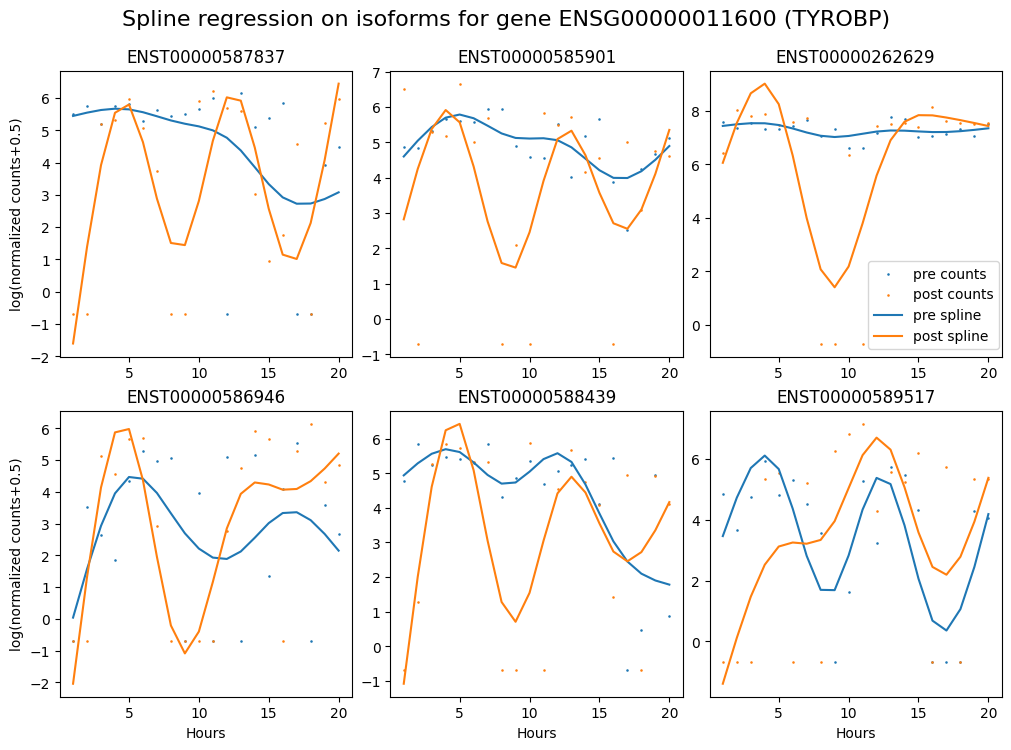

In [31]:
# Plot for gene TYROBP
f = plot_genes('ENSG00000011600', cols=3, figsize=(10, 7))
#f.savefig('TYROBP_splines.png', dpi=300, bbox_inches='tight')

In [33]:
from matplotlib.lines import Line2D
def plot_isoforms(target_gene, ax, mode, cmap):
    '''
    Plots the splines for all isoforms in one plot for a given gene for a given condition.
    This is an auxiliary function for plot_isoform_switching().
    
    Arguments:
        target_gene (str): Gene ID in the form of ENSG...
        ax (matplotlib.axes): ax object to plot on
        mode (str): vaccination condition, given by either 'pre' or 'post'
        cmap (str): name of colormap to use for the plots
        
    Returns:
        ax (matplotlib.axes): the plot with all isoform splines overlayed in one ax object
    '''
    targets = list(de_tx[de_tx['ens_gene']==target_gene]['target_id'])
    
    if mode=='pre':
        for i in range(len(targets)):
            pre = generate_plot(targets[i])[0]
            ax.plot(np.arange(20)+1, pre, label=targets[i], c=cmap(i))
    elif mode=='post':
        for i in range(len(targets)):
            post = generate_plot(targets[i])[1]
            ax.plot(np.arange(20)+1, post, label=targets[i], c=cmap(i))
    else:
        raise Exception('invalid mode, should be pre or post')

    ax.set_xlabel('Hours')
    ax.set_ylabel('log(normalized counts+0.5)')
    return ax

In [36]:
def calc_isoform_fractions(target_id):
    '''
    Calculates the fraction that each isoform of a given gene contributes to the gene's total expression.
    
    Arguments:
        target_id (str): gene ID in the form of ENSG...
    
    Returns:
        iso_frac (pd.DataFrame): dataframe with each isoform as a row and each column as time point
    '''
    targets = list(de_tx[de_tx['ens_gene']==target_id]['target_id'])
    tpms = tpm.loc[targets]
    iso_frac = tpms.div(tpms.sum(axis=0)).fillna(0.0)
    return iso_frac

In [37]:
calc_isoform_fractions('ENSG00000197111')

,052515H11,052515H12,052515H13,052515H14,052515H15,052515H16,052515H17,052515H18,052515H19,052515H20,...,060715H21,060715H22,060715H23,060715H24,060815H01,060815H02,060815H03,060815H04,060815H05,060815H06
ENST00000359282,0.142101,0.195146,0.000000,0.048189,0.000000,0.113228,0.157845,0.012668,0.102259,0.061691,...,0.556849,0.121938,2.521502e-01,0.303823,0.621219,0.000000,0.184386,0.069109,0.140172,0.322605
ENST00000359462,0.180191,0.174816,0.261744,0.227573,0.277779,0.266746,0.288844,0.188336,0.113093,0.010576,...,0.000000,0.146027,1.054866e-01,0.441571,0.194569,0.007146,0.343034,0.361389,0.184094,0.202924
ENST00000552296,0.348433,0.129167,0.403605,0.326548,0.333338,0.250349,0.163832,0.254011,0.222601,0.402405,...,0.000000,0.215124,1.791043e-01,0.007264,0.009324,0.693611,0.151270,0.281691,0.263552,0.292042
ENST00000552819,0.114080,0.260636,0.055179,0.137594,0.134618,0.146500,0.103270,0.148188,0.247895,0.000001,...,0.104203,0.225526,2.964681e-01,0.000000,0.049690,0.299243,0.093056,0.077678,0.214615,0.005337
ENST00000550585,0.038016,0.034051,0.020443,0.022169,0.035511,0.027534,0.025071,0.047738,0.040292,0.182897,...,0.000000,0.063500,0.000000e+00,0.000410,0.001761,0.000000,0.021683,0.007674,0.029613,0.010442
ENST00000553064,0.049367,0.053744,0.064710,0.013654,0.023024,0.045249,0.028150,0.029600,0.061693,0.039994,...,0.000000,0.037985,6.725993e-02,0.018168,0.023879,0.000000,0.026150,0.042743,0.015167,0.059249
ENST00000547859,0.034653,0.041930,0.002168,0.094651,0.009698,0.040900,0.052751,0.069261,0.045995,0.086908,...,0.006914,0.086888,1.405168e-08,0.112377,0.063167,0.000000,0.022977,0.086128,0.052885,0.063856
ENST00000547048,0.093159,0.110509,0.192150,0.129622,0.186031,0.109493,0.180238,0.250197,0.166172,0.215528,...,0.332034,0.103012,9.953088e-02,0.116387,0.036390,0.000000,0.157446,0.073588,0.099903,0.043546


In [40]:
def plot_isoform_fractions(target_id, ax, mode, cmap):
    '''
    Plots the isoform fractions for all isoforms of a given gene, using the fractions from calc_isoform_fractions().
    This is an auxiliary function for plot_isoform_switching().
    Arguments:
        target_id (str): gene ID to be passed into calc_isoform_fractions(), in the form of ENSG...
        ax (matplotlib.axes): ax object to plot on
        mode (str): vaccination condition, given by either 'pre' or 'post'
        cmap (str): name of colormap to use for the plots
    
    Returns:
        ax (matplotlib.axes): the plot with all isoform fractions for all time points, plotted as stacked bar charts 
    '''
    iso_frac = calc_isoform_fractions(target_id)
    if mode == 'pre':
        df = iso_frac.iloc[:, :20]
    elif mode == 'post':
        df = iso_frac.iloc[:, 20:]
    else:
        raise Exception('invalid mode, should be pre or post')
    df.columns = np.arange(20)+1
    bottom = np.zeros(df.shape[1])  # Track bottom position for stacking
    for i in range(df.shape[0]):
        ax.bar(df.columns, df.iloc[i], bottom=bottom, color=cmap(i))#, label=f"Row {row_idx}")
        bottom += df.iloc[i]  # Update bottom for stacking
    ax.set_xlabel("Hours")
    ax.set_ylabel("Isoform Fractions")
    return ax

In [39]:
def plot_gene_agg_ax(target_gene, ax, mode):
    '''
    Plots the TPM-aggregated gene-level expression for a given gene and vaccination condition.
    
    Arguments:
        target_gene (str): gene ID to plot the expression for, in the form of ENSG...
        ax (matplotlib.axes): ax object to plot on 
        mode (str): vaccination condition, given by either 'pre' or 'post'
        
    Returns:
        ax (matplotlib.axes): the plot with gene-level expression from aggregated isoform expression levels
    '''
    targets = list(de_tx[de_tx['ens_gene']==target_gene]['target_id'])
    x = np.arange(20)+1
    
    tpms = tpm.loc[targets]
    tpms = tpms.sum(axis=0)
    
    pre_counts = tpms.loc['052515H11':'052615H06']
    post_counts = tpms.loc['060715H11':'060815H06']
    
    if mode=='pre':
        plt.plot(x, pre_counts, c='black')#, label='pre-vax counts (tpm)')
    elif mode=='post':
        plt.plot(x, post_counts, c='black')#, label='post-vax counts (tpm)')
    else:
        raise Exception('invalid mode, should be pre or post')
    plt.xlabel('Hours')
    plt.ylabel('Summed Normalized Counts (tpm)')
    
    return ax

In [41]:
def plot_isoform_switching(target_gene, mode):
    '''
    For a given gene, generate a panel of plots that show isoform switching.
    
    Arguments:
        target_gene (str): gene ID to plot the expression for, in the form of ENSG...
        mode (str): vaccination condition, given by either 'pre' or 'post'
    
    Returns:
        fig: figure with three subplots, which are the isoform splines (top), isoform fraction bar chart
        (bottom left), and aggregated gene-level expression (bottom right)
    '''
    targets = list(de_tx[de_tx['ens_gene']==target_gene]['target_id'])
    cmap = plt.get_cmap('Paired', len(targets))
    fig = plt.figure(layout='constrained', figsize=(13, 7))
    
    ax_dict = fig.subplot_mosaic(
        [
            ["splines", "splines"],
            ["frac", "sum"],
        ],
    )
    plot_gene_agg_ax(target_gene, ax_dict['sum'], mode)
    plot_isoforms(target_gene, ax_dict['splines'], mode, cmap)
    handles, labels = ax_dict['splines'].get_legend_handles_labels()
    plot_isoform_fractions(target_gene, ax_dict['frac'], mode, cmap)
    fig.legend(handles, labels, loc='outside center right')
    ext_gene_name = de[de['target_id']==target_gene]['ext_gene'].iloc[0]
    fig.suptitle(f'Isoform Switching for {ext_gene_name}, {mode}-vaccination')
    return fig

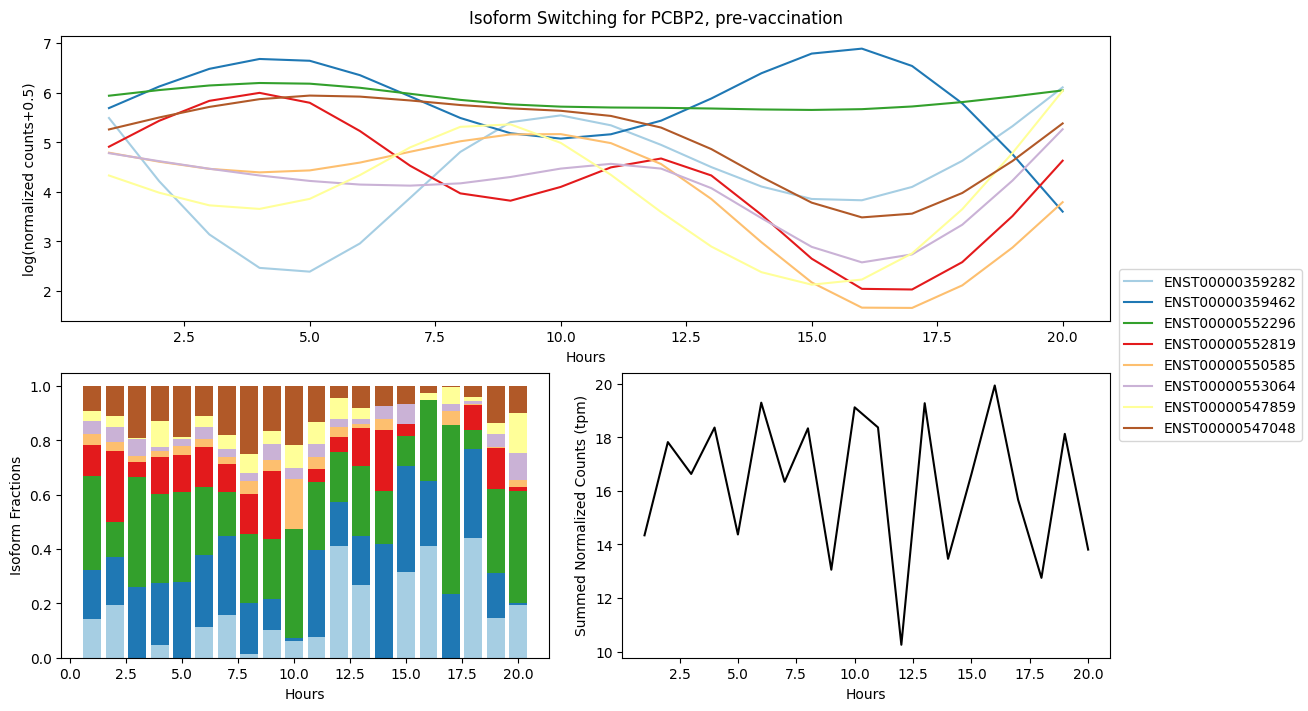

In [42]:
f = plot_isoform_switching('ENSG00000197111', 'pre')
#f.savefig('isoform_switching_pcbp2.png', dpi=300, bbox_inches='tight')

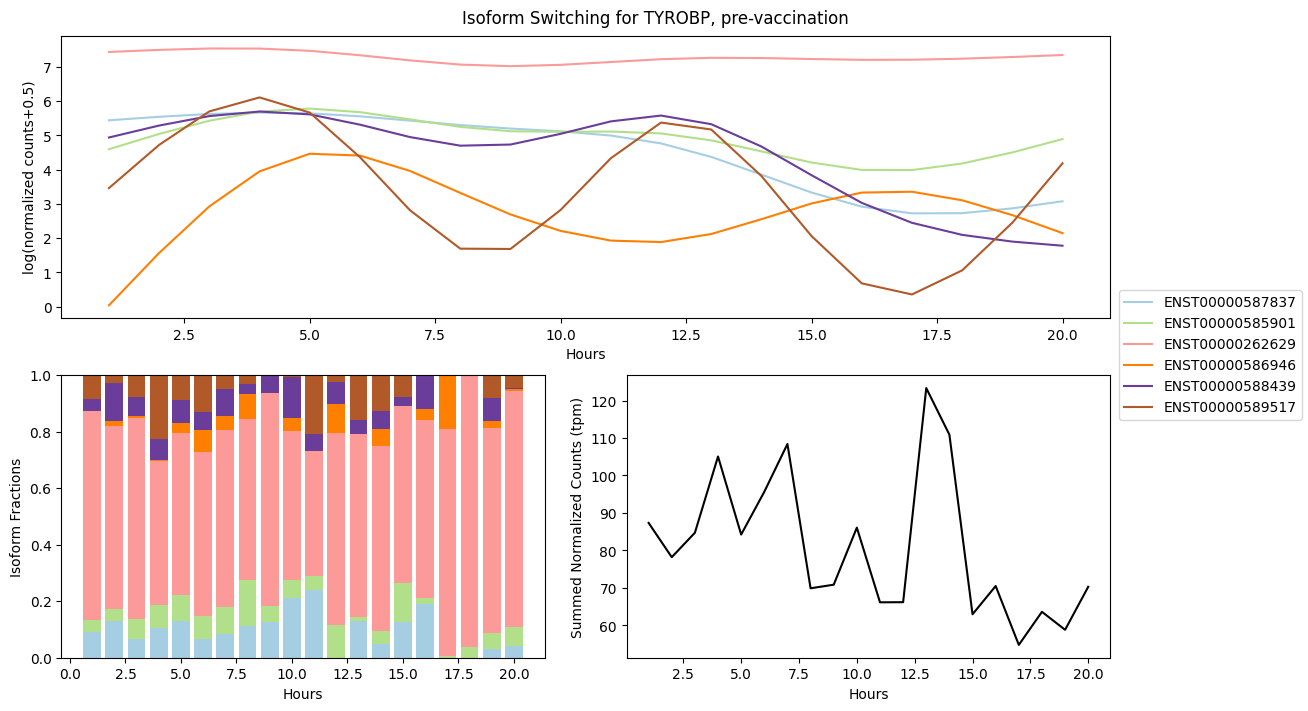

In [43]:
f = plot_isoform_switching('ENSG00000011600', 'pre')
#f.savefig('isoform_switching_stxbp2.png', dpi=300, bbox_inches='tight')

## Calculating R2 values

In [ ]:
pre, post, pre_counts, post_counts = generate_plot('ENST00000621758')
pre_r2 = r2_score(pre_counts, pre)
post_r2 = r2_score(post_counts, post)
pre_r2, post_r2

In [ ]:
df5_r2_dict = {}
top_genes = de['target_id'].tolist()
pre_r2s_20 = []
post_r2s_20 = []

for gene in top_genes:
    targets = list(de_tx[de_tx['ens_gene']==gene]['target_id'])
    pre_r2s = []
    post_r2s = []
    for target in targets:
        pre, post, pre_counts, post_counts = generate_plot(target)
        r2 = r2_score(pre_counts, pre)
        pre_r2s.append(r2)
        r2 = r2_score(post_counts, post)
        post_r2s.append(r2)
        pre_r2s_20.append(np.mean(pre_r2s))
        post_r2s_20.append(np.mean(post_r2s))
    df5_r2_dict[gene] = (len(targets), np.mean(pre_r2s), np.mean(post_r2s))

In [ ]:
np.mean(pre_r2s_20), np.mean(post_r2s_20)

## Plotting bootstraps (Unused)

In [ ]:
with h5py.File('hourly_bs_summary.h5', 'r') as f:
    result_array = f['result_array'][:]
    #result_array = result_array.transpose(2, 1, 0)
    print(result_array.shape)  # Should print (3160, 40, 6)

In [ ]:
transcript_ids = [
        result_array[:, row, col][-1].decode('utf-8').strip()  # Decode transcript ID
        for row in range(result_array.shape[1])
        for col in range(result_array.shape[2])
    ]

In [ ]:
# need to load in the tx with versions
with open('reordered_transcripts_with_versions.txt', 'r') as f:
    versioned_ids = [line.strip() for line in f]
# Create the dictionary
transcript_dict = {id.split('.')[0]: id for id in versioned_ids}

In [ ]:
def get_transcript_data(transcript_id, result_array):
    """
    Fetch a 40x5 array for the given transcript ID.
    
    Parameters:
        transcript_id (str): The transcript ID to search for.
        result_array (np.ndarray): The full dataset array.
        
    Returns:
        np.ndarray: A 40x5 array where rows correspond to the second dimension
                    and columns correspond to the numerical values.
    """
    # Extract transcript IDs from the dataset
    transcript_ids = [
        result_array[:, row, col][-1].decode('utf-8').strip()  # Decode transcript ID
        for row in range(result_array.shape[1])
        for col in range(result_array.shape[2])
    ]
    
    try:
        idx = transcript_ids.index(transcript_id)
    except ValueError:
        raise ValueError(f"Transcript ID {transcript_id} not found in the dataset.")
    # - Rows correspond to the second dimension (40 rows)
    # - Columns correspond to the first 5 elements of the first dimension
    numerical_data = result_array[:5, :, idx].T  # Transpose to get 40x5 format
    numerical_data = numerical_data.astype(float)
    return numerical_data

In [ ]:
def get_bs_summaries(transcript_id, result_array):
    transcript_data = get_transcript_data(transcript_id, result_array)
    pre = transcript_data[:20, :]
    post = transcript_data[20:40, :]
    pre_stats = []
    post_stats = []
    for i in range(20):
        temp_dict = {'med':pre[i,2], 
                     'q1':pre[i,1], 
                     'q3':pre[i,3], 
                     'whislo':pre[i,0], 
                     'whishi':pre[i,4], 
                     'label':int(i), 
                     'fliers':[]}
        pre_stats.append(temp_dict)
        temp_dict = {'med':post[i,2], 
                     'q1':post[i,1], 
                     'q3':post[i,3], 
                     'whislo':post[i,0], 
                     'whishi':post[i,4], 
                     'label':int(i), 
                     'fliers':[]}
        post_stats.append(temp_dict)
    return pre_stats, post_stats

In [ ]:
pre_stats, post_stats = get_bs_summaries(transcript_dict['ENST00000587837'], result_array)
fig, ax = plt.subplots()
ax.plot(generate_plot('ENST00000587837')[1], color='orange')
ax.bxp(post_stats, patch_artist=True, boxprops={'facecolor': 'orange'}, positions=np.arange(20))
ax.set_xlabel('Time (Hours)')
ax.set_ylabel('log(bootstrap+0.5)')
ax.set_title('Post-vaccination')
plt.show()